## Exercise 1

In [1]:
import pandas as pd
from math import log2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Y = "SalePrice"
path = "AmesHousing.csv"
df = pd.read_csv(path)

In [2]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Exercise 2 

In [3]:
# Following variables are 
#     - numerical (`float64(11), int64(28)`):
#     - categorical (`object(43)`):
#     - both (`(82)`)
df.info()
# - most of the variables are complete, exception of some like: `"Alley", "Mas Vnr Type", "Fireplace Qu", "Pool QC", "Fence", "Misc Feature"`
#     `SalePrice` is _complete_

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [4]:
# for freq table, see `nans_count` dictionary
nans_count: dict[str, int] = {}
for col in df.columns:
    # total rows - counted rows (since NaNs are not existing values)
    nans_count[col] = len(df) - df[col].count()

In [5]:
# below are 2 descriptive summaries about the categorical and numeric data
numeric_df = df.select_dtypes("number")
numeric_df.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [6]:
categorical_df = df.select_dtypes("object")
categorical_df.describe()

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
count,2930,2930,198,2930,2930,2930,2930,2930,2930,2930,...,2773,2771,2771,2771,2930,13,572,106,2930,2930
unique,7,2,2,4,4,3,5,3,28,9,...,6,3,5,5,3,4,4,5,10,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,2273,2918,120,1859,2633,2927,2140,2789,443,2522,...,1731,1231,2615,2665,2652,4,330,95,2536,2413


In [7]:
# calc the mode (most frequent value), but to only show 1 row, we set dropna to False for readability (even tho NaN is most frequent value)
categorical_df.mode(dropna=False)

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,...,Garage Type,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Sale Type,Sale Condition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [8]:
df["Alley"].value_counts(dropna=False)

Alley
NaN     2732
Grvl     120
Pave      78
Name: count, dtype: int64

## Exercise 3

In [9]:
num_df = df.select_dtypes("number")
df[num_df.columns] = df[num_df.columns].fillna(num_df.median())
# set as category for mem usage reduction
# df[num_cols.columns] = num_cols.astype("")

In [10]:
cat_df = df.select_dtypes("object")
df[cat_df.columns] = df[cat_df.columns].fillna("other")
# set as category for mem usage reduction
df[cat_df.columns] = df[cat_df.columns].astype("category")


In [11]:
df.isnull().values.any()

False

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Order            2930 non-null   int64   
 1   PID              2930 non-null   int64   
 2   MS SubClass      2930 non-null   int64   
 3   MS Zoning        2930 non-null   category
 4   Lot Frontage     2930 non-null   float64 
 5   Lot Area         2930 non-null   int64   
 6   Street           2930 non-null   category
 7   Alley            2930 non-null   category
 8   Lot Shape        2930 non-null   category
 9   Land Contour     2930 non-null   category
 10  Utilities        2930 non-null   category
 11  Lot Config       2930 non-null   category
 12  Land Slope       2930 non-null   category
 13  Neighborhood     2930 non-null   category
 14  Condition 1      2930 non-null   category
 15  Condition 2      2930 non-null   category
 16  Bldg Type        2930 non-null   category


## Exercise 4

In [13]:
desc = df.SalePrice.describe()
desc["median"] = df.SalePrice.median(0)
desc

count       2930.000000
mean      180796.060068
std        79886.692357
min        12789.000000
25%       129500.000000
50%       160000.000000
75%       213500.000000
max       755000.000000
median    160000.000000
Name: SalePrice, dtype: float64

<Axes: >

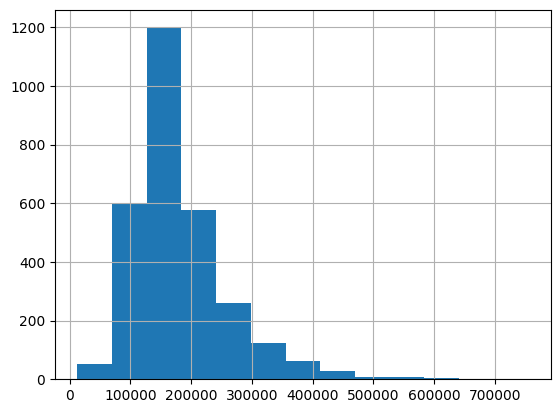

In [14]:
def calc_bins(series: pd.Series) -> int:
    """calc bins using Sturge's rules"""
    n = len(series)
    return round(log2(n) + 1)

df.SalePrice.hist(bins=calc_bins(df.SalePrice))
# observation: most houses have a sale price of around 100k to 250k, with a peak at 150k
# which means there is going to be a bias towards this peak if the test/train split is not equally divided

<Axes: >

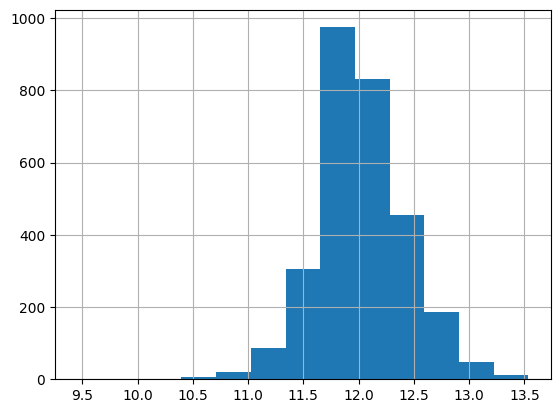

In [15]:
df["log_Y"] = np.log(df["SalePrice"])
df["log_Y"].hist(bins=calc_bins(df["log_Y"]))

<Axes: xlabel='Gr Liv Area', ylabel='SalePrice'>

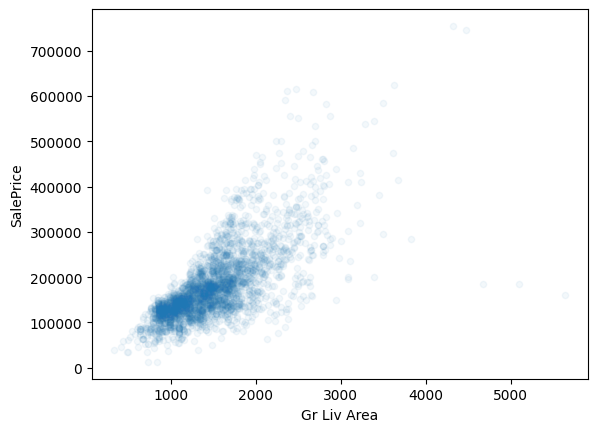

In [16]:
# By changing the transparency of each observation, we can see better patterns (`alpha` kwarg)
df.plot.scatter(x="Gr Liv Area", y="SalePrice", alpha=0.05)

In [17]:
# removal of outliers, outliers are defined by calculating their respective z-score
array = df["Gr Liv Area"]
df["Gr Liv Area_zscores"] = np.abs((array - array.mean()) / array.std())
outliers = df[df["Gr Liv Area_zscores"] > 2]
outliers[["Gr Liv Area"]]
# removing the outliers narrows the scope of the model and adds to the bias!

,Gr Liv Area
15,3279
46,2696
59,2599
62,2622
65,3238
...,...
2747,2559
2880,480
2891,2519
2897,2514


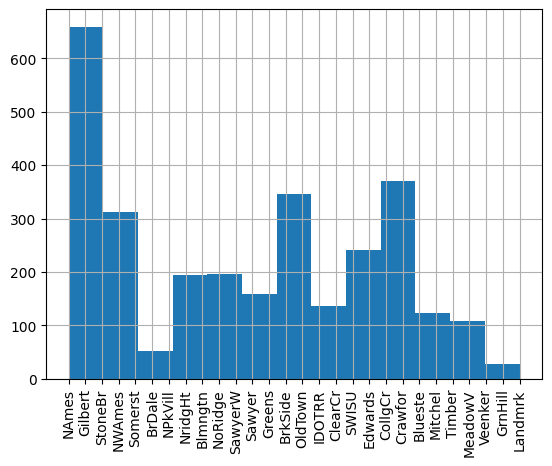

In [18]:
hist = df.Neighborhood.hist(bins=calc_bins(df.Neighborhood))
plt.xticks(rotation=90)
plt.show()

In [19]:
df.Neighborhood.value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64

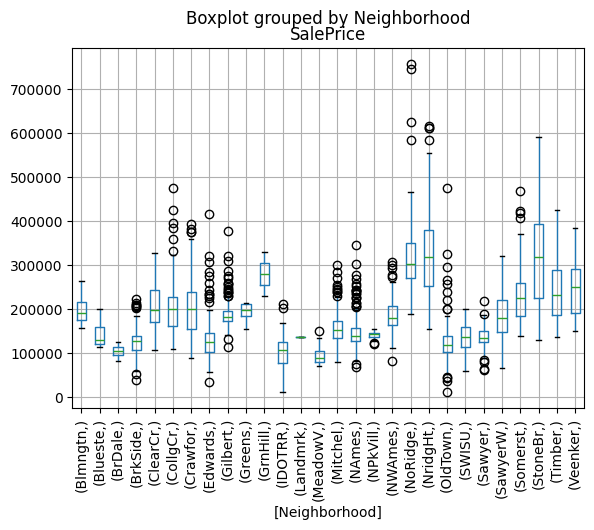

In [20]:
boxplot = df.boxplot(column=["SalePrice"] ,by=["Neighborhood"])
plt.xticks(rotation=90)
plt.show()

In [21]:
df.SalePrice.describe()

count      2930.000000
mean     180796.060068
std       79886.692357
min       12789.000000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      755000.000000
Name: SalePrice, dtype: float64

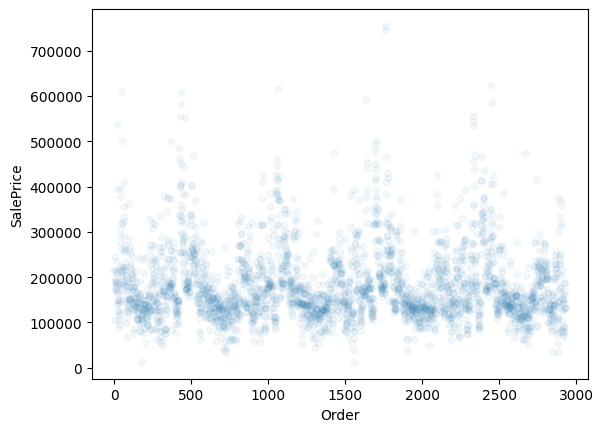

In [22]:
for col in numeric_df.columns:
    numeric_df.plot.scatter(x=col, y="SalePrice", alpha=0.05)
    break  # to prevent 20 figures from opening in notebook

In [23]:
# Pearson correlation coefficients:
# most used manner in order to calculate a linear correlation, 
# resulting in a correlation coefficient (r)
# 0<=1: positive corr
# 0: no corr
# -1=>0: negative corr
corr_table = numeric_df.corr()
corr_table

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
Order,1.000000,0.173593,0.011797,-0.007034,0.031354,-0.048500,-0.011054,-0.052319,-0.075566,-0.030907,...,-0.011292,0.016355,0.027908,-0.024975,0.004307,0.052518,-0.006083,0.133365,-0.975993,-0.031408
PID,0.173593,1.000000,-0.001281,-0.096918,0.034868,-0.263147,0.104451,-0.343388,-0.157111,-0.229283,...,-0.051135,-0.071311,0.162519,-0.024894,-0.025735,-0.002845,-0.008260,-0.050455,0.009579,-0.246521
MS SubClass,0.011797,-0.001281,1.000000,-0.420135,-0.204613,0.039419,-0.067349,0.036579,0.043397,0.002730,...,-0.017310,-0.014823,-0.022866,-0.037956,-0.050614,-0.003434,-0.029254,0.000350,-0.017905,-0.085092
Lot Frontage,-0.007034,-0.096918,-0.420135,1.000000,0.491313,0.212042,-0.074448,0.121562,0.091712,0.222407,...,0.120084,0.163040,0.012758,0.028564,0.076666,0.173947,0.044476,0.011085,-0.007547,0.357318
Lot Area,0.031354,0.034868,-0.204613,0.491313,1.000000,0.097188,-0.034759,0.023258,0.021682,0.126830,...,0.157212,0.103760,0.021868,0.016243,0.055044,0.093775,0.069188,0.003859,-0.023085,0.266549
Overall Qual,-0.048500,-0.263147,0.039419,0.212042,0.097188,1.000000,-0.094812,0.597027,0.569609,0.429418,...,0.255663,0.298412,-0.140332,0.018240,0.041615,0.030399,0.005179,0.031103,-0.020719,0.799262
Overall Cond,-0.011054,0.104451,-0.067349,-0.074448,-0.034759,-0.094812,1.000000,-0.368773,0.047680,-0.135340,...,0.020344,-0.068934,0.071459,0.043852,0.044055,-0.016787,0.034056,-0.007295,0.031207,-0.101697
Year Built,-0.052319,-0.343388,0.036579,0.121562,0.023258,0.597027,-0.368773,1.000000,0.612095,0.313292,...,0.228964,0.198365,-0.374364,0.015803,-0.041436,0.002213,-0.011011,0.014577,-0.013197,0.558426
Year Remod/Add,-0.075566,-0.157111,0.043397,0.091712,0.021682,0.569609,0.047680,0.612095,1.000000,0.196928,...,0.217857,0.241748,-0.220383,0.037412,-0.046888,-0.011410,-0.003132,0.018048,0.032652,0.532974
Mas Vnr Area,-0.030907,-0.229283,0.002730,0.222407,0.126830,0.429418,-0.135340,0.313292,0.196928,1.000000,...,0.165467,0.143748,-0.110787,0.013778,0.065643,0.004617,0.044934,-0.000276,-0.017715,0.508285


<Axes: >

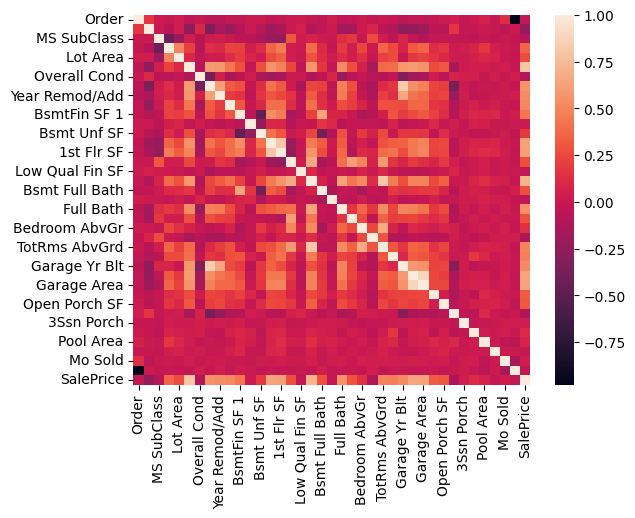

In [24]:
sns.heatmap(corr_table)
